In [42]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk

## Run on kaglle
# nltk.download('wordnet', download_dir = "/kaggle/working/nltk_data")
# nltk.download('averaged_perceptron_tagger',download_dir = "/kaggle/working/nltk_data") 

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
np.random.seed(2023)
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [43]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Data Understanding


In [9]:
direct = "data/"
filename = os.listdir('data')
directFileName = []
datafile = []
for name in filename:
    if 'json' in name:
        directFileName.append(os.path.join(direct, name))
        datafile.append(name)
        
directFileName

['data/Business.json',
 'data/Company.json',
 'data/Culture.json',
 'data/Education.json',
 'data/Environment.json',
 'data/Football.json',
 'data/GlobalHealthSecurity.json',
 'data/Health.json',
 'data/Market.json',
 'data/Politics.json',
 'data/Science.json',
 'data/Style.json',
 'data/Technology.json',
 'data/Travel.json']

### Format of data


In [10]:
with open("data/Business.json") as file:
    business = json.load(file)


**Count NONE content articles**

In [11]:
countDict = {}
for name in datafile:
    
    cate = name.split('.')[0]
    name = os.path.join(direct, name)
    with open(name, 'r') as file:
        data = json.load(file)
    countDict[cate] = {}
    countDict[cate]["Length"] = len(data.keys())
    countNone = 0
    for key in data.keys():
        if data[key]['Content'] == "None":
            countNone += 1
    countDict[cate]["None content"] = countNone
        

In [12]:
countDict

{'Business': {'Length': 7943, 'None content': 10},
 'Company': {'Length': 4743, 'None content': 0},
 'Culture': {'Length': 12736, 'None content': 5961},
 'Education': {'Length': 1542, 'None content': 1},
 'Environment': {'Length': 2177, 'None content': 10},
 'Football': {'Length': 9533, 'None content': 21},
 'GlobalHealthSecurity': {'Length': 5052, 'None content': 89},
 'Health': {'Length': 6336, 'None content': 35},
 'Market': {'Length': 4743, 'None content': 2},
 'Politics': {'Length': 9535, 'None content': 39},
 'Science': {'Length': 3128, 'None content': 46},
 'Style': {'Length': 4736, 'None content': 17},
 'Technology': {'Length': 11141, 'None content': 78},
 'Travel': {'Length': 9532, 'None content': 38}}

We can see that there are a lot of articles with None cotent in Culture. The reason is that in this category, there are many article of review without content.

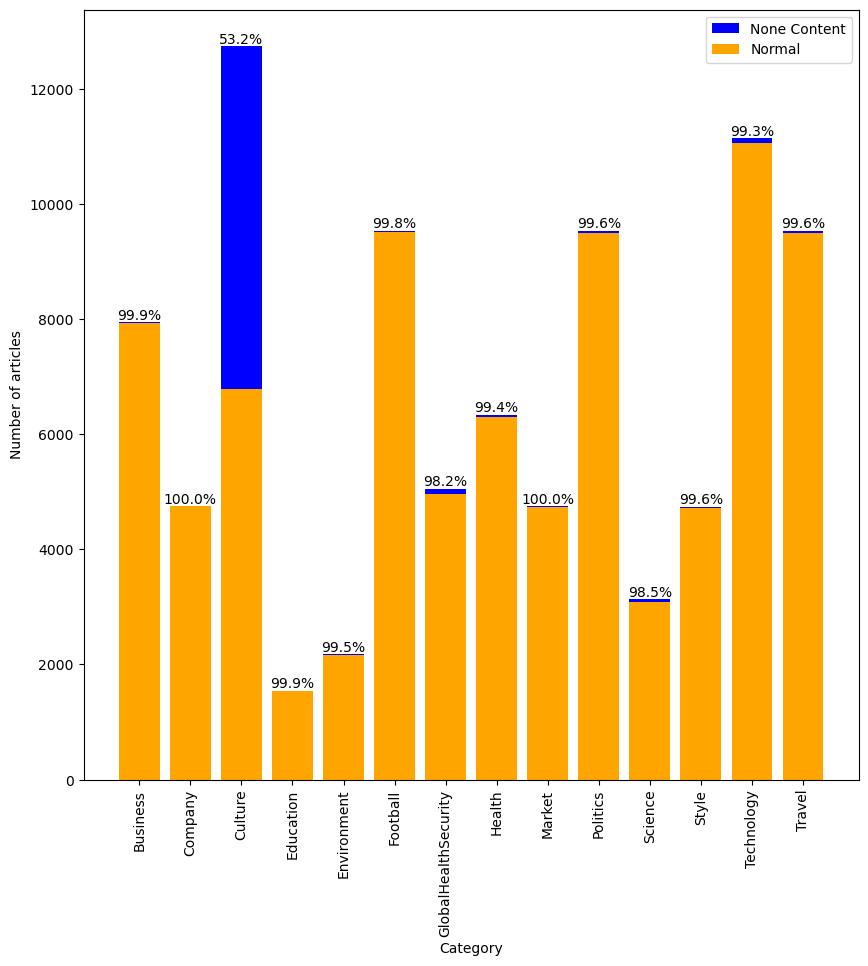

In [13]:

totalList = []
noneList = []
for key in countDict.keys():
    totalList.append(countDict[key]["Length"])
    noneList.append(countDict[key]["None content"])
arr1 = np.array(totalList)
arr2 = arr1 - np.array(noneList)
# Calculate the percentages
percentages = (arr2 / arr1) * 100

# Set up the bar positions
bar_positions = list(countDict.keys())
plt.figure(figsize = (10,10))
# Plot the bars with percentages
plt.bar(bar_positions, arr1, color='blue', label='None Content')
plt.bar(bar_positions, arr2, color='orange', label='Normal')

# Display percentages on the bars
for i, percentage in enumerate(percentages):
    plt.text(bar_positions[i], arr1[i] + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Number of articles')
plt.xticks(bar_positions, countDict.keys(), rotation='vertical')
plt.legend()
plt.savefig('NoneContent.png')
# Show the plot
plt.show()


**From this graph, we can see that our dataset is imbalance. The fact is that there some category that many people are interested in such as Business, Culture, Politics, Sports,... so the journalists intend to produce more articles in these types (Number of Culture is more than sixth of Education). This face suggest us some models to avoid bias from data**

## The average length of article in each category

In [15]:
with open("data/Business.json", 'r') as file:
    data = json.load(file)
len(data['1']['Content'].split())

496

In [16]:
arrLength = []
arrName = []
for name in directFileName:
    with open(name, 'r') as file:
        data = json.load(file)
    ave = 0
    for key in data.keys():
        ave += len(data[key]['Content'].split())
    ave = ave / len(data.keys())
    arrLength.append(round(ave))
    arrName.append(name.split('/')[-1].split('.')[0])
    print(f"Category {name.split('/')[-1].split('.')[0]} has average of length {round(ave)}")

Category Business has average of length 793
Category Company has average of length 555
Category Culture has average of length 729
Category Education has average of length 662
Category Environment has average of length 717
Category Football has average of length 967
Category GlobalHealthSecurity has average of length 2171
Category Health has average of length 840
Category Market has average of length 2024
Category Politics has average of length 967
Category Science has average of length 594
Category Style has average of length 994
Category Technology has average of length 679
Category Travel has average of length 1509


In [17]:
arrLength

[793, 555, 729, 662, 717, 967, 2171, 840, 2024, 967, 594, 994, 679, 1509]

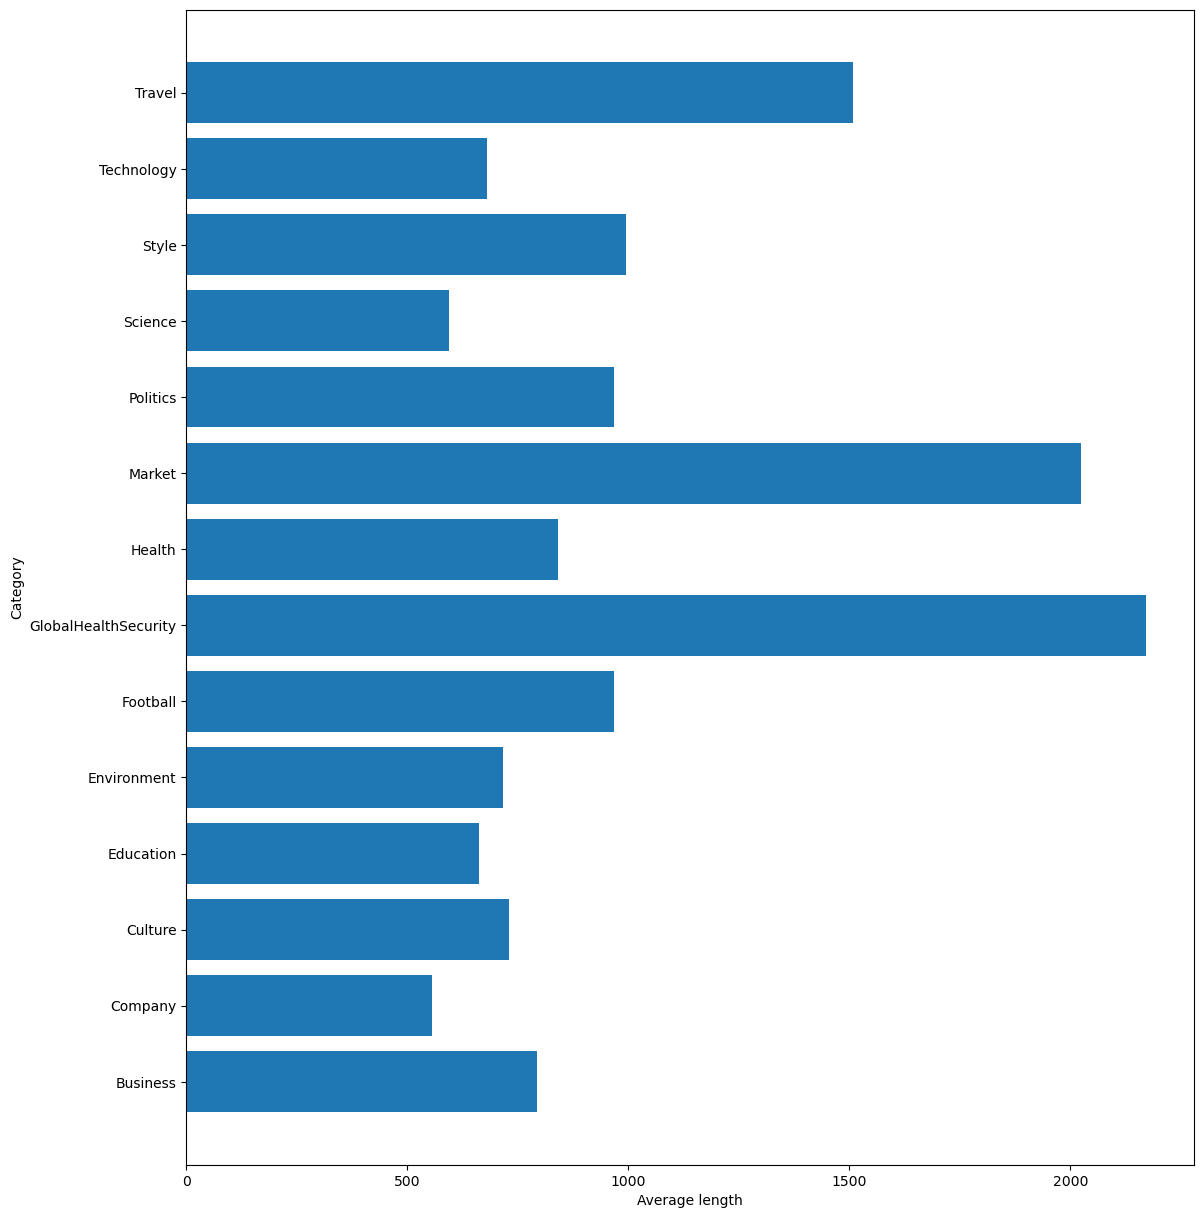

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 15))
plt.barh(arrName, arrLength)  # Use barh for horizontal bars

plt.yticks(arrName, arrName)  # Use yticks instead of xticks for horizontal bars
plt.xlabel("Average length")
plt.ylabel('Category')
plt.savefig("average_length_vertical.png")  # Change the filename if needed
plt.show()

**We can see that each article have different length (each of them is also big), therefore it is hard for us to use each word as feature to pass into Machine Learning model. We have to try Language Model or have other ways to process data to get fixed features for traditional Machine learning algorithm**

# Statistics
**List the frequency of words in each category with raw text**

In [26]:
!pip install wordcloud

     ------------------------------------- 300.6/300.6 kB 27.3 kB/s eta 0:00:00


In [27]:
from wordcloud import WordCloud

In [21]:
def count_word_appearances(sentence, wordDict):
    # Split the sentence into words
    words = sentence.split()


    # Iterate through each word in the list
    for word in words:
        wordDict[word] = wordDict.get(word, 0) + 1

    return wordDict
def mostFrequentWord(content = None, path = None):
    myDict = {}
    if path:
        with open(path, 'r') as file:
            data = json.load(file)
        totalDoc = ""
        countDrop = 0
        for key in data.keys():
            if data[key]['Content'] != "None":
                totalDoc += " " + data[key]['Content']
            else:
                countDrop += 1
        print(f"Number of articles with no content is {countDrop}")
    else: 
        totalDoc = content
    myDict = count_word_appearances(totalDoc, myDict)
    sortedDict = sorted(myDict.items(), key = lambda x:x[1], reverse = True)
    return sortedDict






##### Business

In [22]:
busiDict = mostFrequentWord(path = "data/Business.json")

Number of articles with no content is 10


In [23]:
word = [i[0] for i in busiDict[:30]]
freq = [i[1] for i in busiDict[:30]]

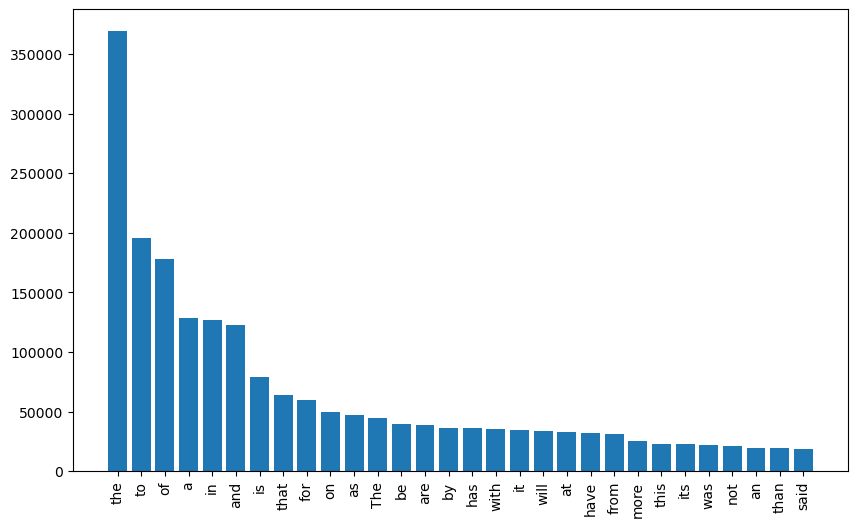

In [24]:
plt.figure(figsize = (10,6))
plt.bar(word, freq)
plt.xticks(word, word, rotation = 'vertical')
plt.savefig("frequentWords.png")
plt.show()

In [28]:
total = 0
for i in busiDict:
    total += i[1]
print(f"\'The\'accounts for {freq[0]/total*100}% of the words ")

'The'accounts for 5.86016564157414% of the words 


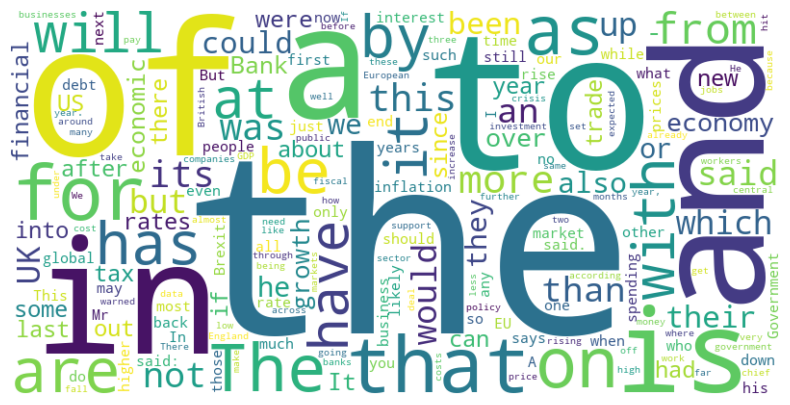

In [29]:
word_freq_dict = dict(busiDict)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.savefig('wordcloud.png')

plt.show()

##### Culture

In [30]:
cultureDict = mostFrequentWord(path = "data/Culture.json")

Number of articles with no content is 5961


In [31]:
word = [i[0] for i in cultureDict[:30]]
freq = [i[1] for i in cultureDict[:30]]

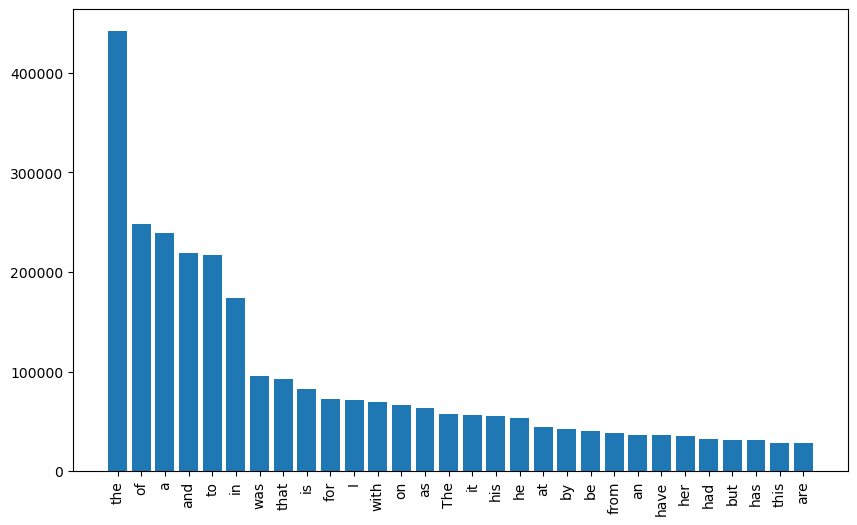

In [32]:
plt.figure(figsize = (10,6))
plt.bar(word, freq)
plt.xticks(word, word, rotation = 'vertical')
plt.savefig("frequentwordd.png")
plt.show()

In [33]:
total = 0
for i in cultureDict:
    total += i[1]
print(f"\'The\' accounts for {freq[0]/total*100}% of the words ")

'The' accounts for 4.760983247923105% of the words 


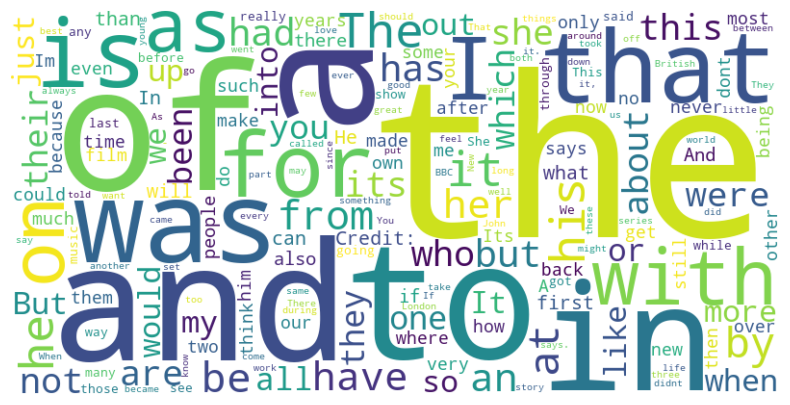

In [34]:
word_freq_dict = dict(cultureDict)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

##### Football

Number of articles with no content is 21


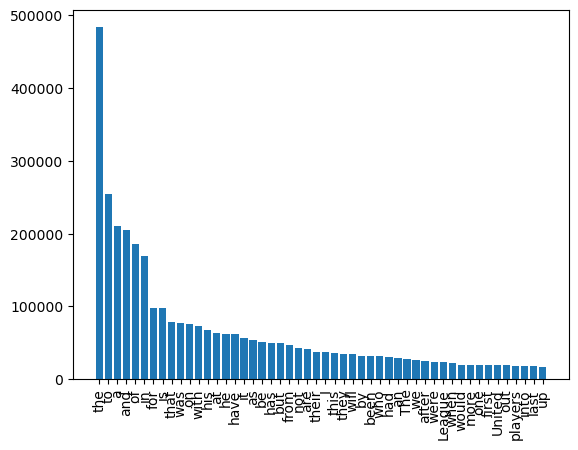

The accounts for 5.239712569593482% of the words 


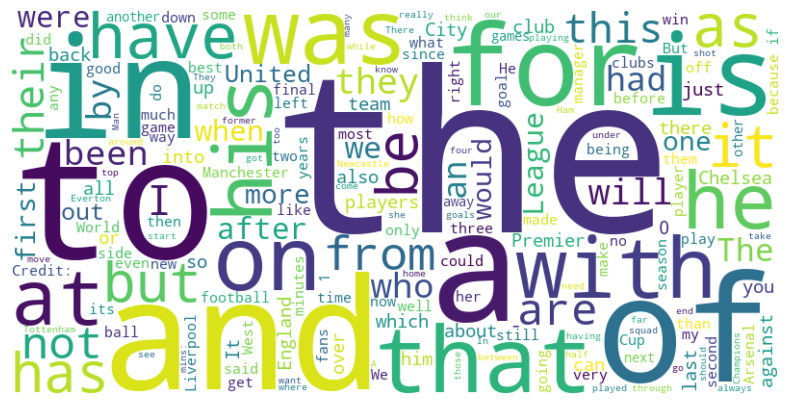

In [35]:
footballDict = mostFrequentWord(path = "data/Football.json")
word = [i[0] for i in footballDict[:50]]
freq = [i[1] for i in footballDict[:50]]
plt.bar(word, freq)
plt.xticks(word, word, rotation = 'vertical')
plt.show()
total = 0
for i in footballDict:
    total += i[1]
print(f"The accounts for {freq[0]/total*100}% of the words ")
word_freq_dict = dict(footballDict)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

# Processing


In [36]:
def lemmatize_stemming(text):
    result = WordNetLemmatizer().lemmatize(text, pos='v')
    result = WordNetLemmatizer().lemmatize(result, pos='n')
    result = WordNetLemmatizer().lemmatize(result, pos='a')
    return result

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return " ".join(result)

In [37]:
def count_word_appearances(sentence, wordDict):
    # Split the sentence into words
    words = sentence.split()


    # Iterate through each word in the list
    for word in words:
        # Remove punctuation and convert to lowercase for case-insensitive counting
        word = word.strip('.,!?"\'').lower()

        wordDict[word] = wordDict.get(word, 0) + 1

    return wordDict

In [38]:
## Wrapping into function
def mostFrequentWord(content = None, path = None):
    myDict = {}
    if path:
        with open(path, 'r') as file:
            data = json.load(file)
        totalDoc = ""
        countDrop = 0
        for key in data.keys():
            if data[key]['Content'] != "None":
                totalDoc += " " + preprocess(data[key]['Content'])
            else:
                countDrop += 1
        print(f"Number of articles with no content is {countDrop}")
    else: 
        totalDoc = preprocess(content)
    myDict = count_word_appearances(totalDoc, myDict)
    sortedDict = sorted(myDict.items(), key = lambda x:x[1], reverse = True)
    return sortedDict

In [39]:
def isNoun(word):
    words = [word]
    ans = nltk.pos_tag(words) 
    val = ans[0][1]
    if(val == 'NN' or val == 'NNS' or val == 'NNPS' or val == 'NNP'): 
        return True 
    return False

In [40]:
def getTopWord(customDict, top_n = 100):
    topNoun = []
    countt = 0
    for word in customDict:
        if (isNoun(word[0])):
            topNoun.append(word[0])
            countt += 1
        if countt == top_n:
            break
    return topNoun

#### Business words

In [44]:
## Đọc data
with open("data/Business.json", 'r') as file:
    businessData = json.load(file)
with open("data/Company.json", "r") as file:
    companyData = json.load(file)
with open("data/Market.json", "r") as file:
    marketData = json.load(file)
    

In [45]:
totalDoc = ""
countDrop = 0

for key in businessData.keys():
    if businessData[key]['Content'] != "None":
        totalDoc += " " + businessData[key]['Content']
    else:
        countDrop += 1
for key in companyData.keys():
    if companyData[key]['Content'] != "None":
        totalDoc += " " + companyData[key]['Content']
    else:
        countDrop += 1
for key in marketData.keys():
    if marketData[key]['Content'] != "None":
        totalDoc += " " + marketData[key]['Content']
    else:
        countDrop += 1
print("Number of articles with None content is: " + str(countDrop))
print("Done!")

Number of articles with None content is: 12
Done!


In [46]:
businessDict = mostFrequentWord(content = totalDoc)
len(businessDict)

80114

In [47]:
topBusiness = getTopWord(businessDict, 100)

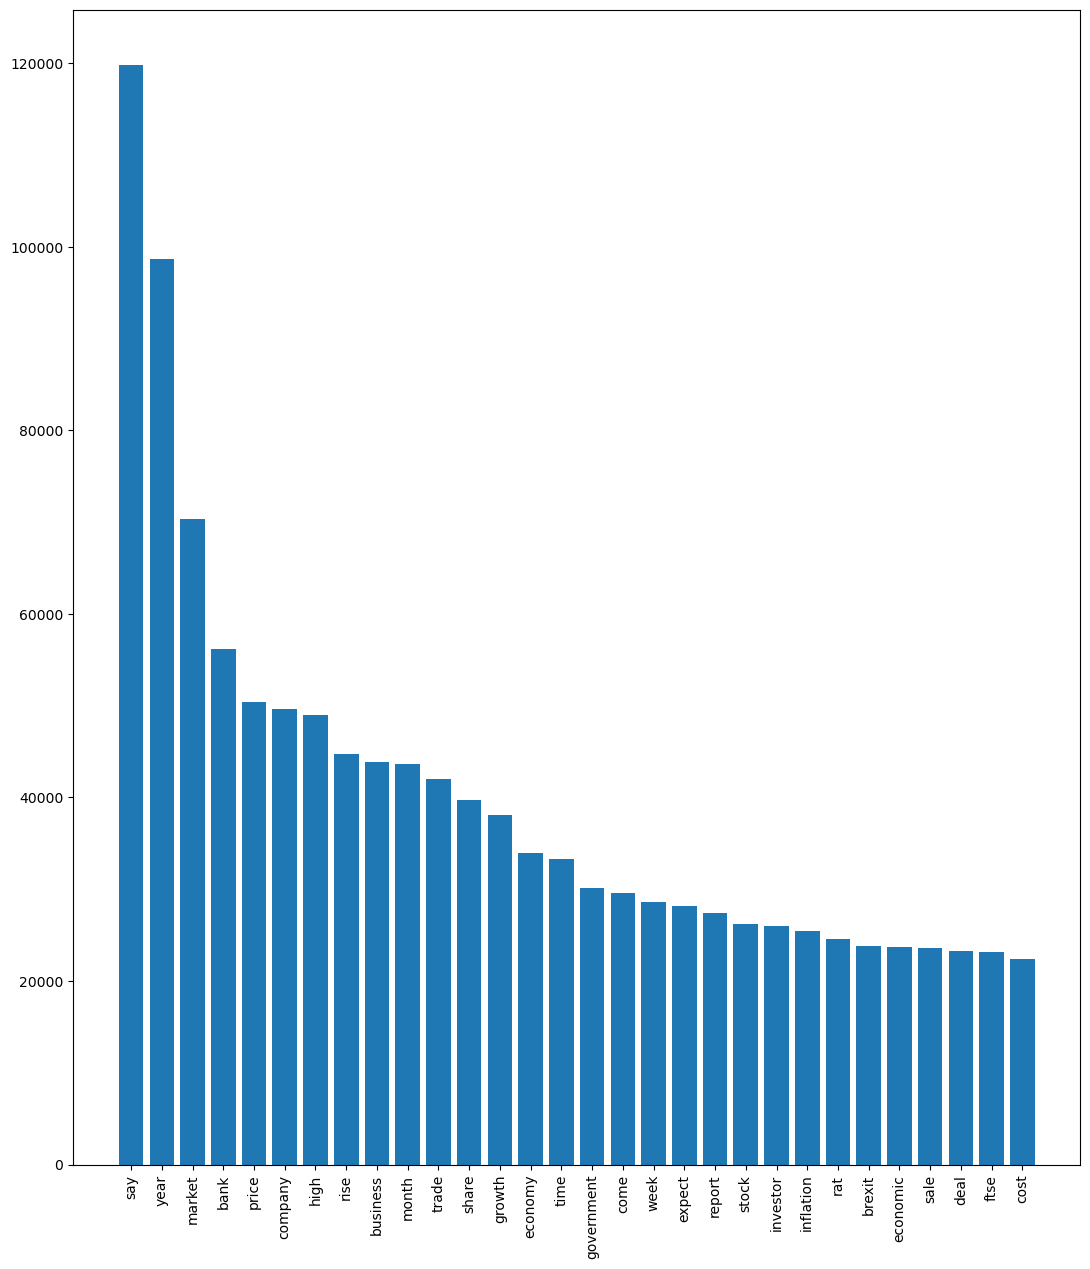

In [48]:
word = [i[0] for i in businessDict[:30]]
freq = [i[1] for i in businessDict[:30]]
plt.figure(figsize = (13,15))
plt.bar(word, freq)
plt.xticks(word, word, rotation = 'vertical')
plt.savefig("process_frequent.png")
plt.show()


# Bigram

In [46]:
# Sample paragraph
# paragraph = "This is a sample several words paragraph. It contains several words for testing bigram extraction in Python several words several."
paragraph = totalDoc[:10000000]
# Tokenize the paragraph into words
words = word_tokenize(paragraph)

# Generate bigrams
bigrams = list(ngrams(words, 2))

# Count the occurrences of each bigram
bigram_counts = Counter(bigrams)

# Display the bigrams and their counts
for bigram, count in bigram_counts.items():
    if count > 4000:
        print(bigram, count)

('of', 'the') 10280
(',', 'and') 4899
('to', 'the') 4463
('in', 'the') 8922
('.', 'The') 5967
(',', 'the') 6582


In [47]:
import pandas as pd

# Your bigrams and frequencies
bigrams = [('in the'), (', and'), ('. The'), ('of the'), ('to the'), (', the')]
frequencies = [8514, 4174, 10209, 10663, 4397, 5773]

# Create a DataFrame
df = pd.DataFrame({'Bigram': bigrams, 'Frequency': frequencies})

# Display the DataFrame
print(df)

   Bigram  Frequency
0  in the       8514
1   , and       4174
2   . The      10209
3  of the      10663
4  to the       4397
5   , the       5773


**Bigram with raw word --> These bigrams do not containt information about their articles**

In [48]:
totalDoc = ""
countDrop = 0

for key in businessData.keys():
    if businessData[key]['Content'] != "None":
        totalDoc += " " + preprocess(businessData[key]['Content'])
    else:
        countDrop += 1
for key in companyData.keys():
    if companyData[key]['Content'] != "None":
        totalDoc += " " + preprocess(companyData[key]['Content'])
    else:
        countDrop += 1
for key in marketData.keys():
    if marketData[key]['Content'] != "None":
        totalDoc += " " + preprocess(marketData[key]['Content'])
    else:
        countDrop += 1
print("Number of articles with None content is: " + str(countDrop))
print("Done!")

Number of articles with None content is: 12
Done!


In [49]:

# Sample paragraph
# paragraph = "This is a sample several words paragraph. It contains several words for testing bigram extraction in Python several words several."
paragraph = totalDoc[0:10000000]
# Tokenize the paragraph into words
words = word_tokenize(paragraph)

# Generate bigrams
bigrams = list(ngrams(words, 2))

# Count the occurrences of each bigram
bigram_counts = Counter(bigrams)

# Display the bigrams and their counts
for bigram, count in bigram_counts.items():
    if count > 1000:
        print(bigram, count)

('bank', 'england') 2565
('central', 'bank') 1656
('long', 'term') 1191


**Some bigrams are meaningful but their frequency are too low ~ 0.2% --> Not enough to be characteristics of these articles**

In [50]:
import pandas as pd

# Provided data
bigrams_data = [('financial crisis', 1368),
                ('long term', 1070),
                ('bank england', 2418),
                ('central bank', 2037)]

# Create a DataFrame
df = pd.DataFrame(bigrams_data, columns=['Bigram', 'Frequency'])

# Display the DataFrame
print(df)

             Bigram  Frequency
0  financial crisis       1368
1         long term       1070
2      bank england       2418
3      central bank       2037


### Frequent Word of each article


In [51]:
with open('data/Business.json', 'r') as file:
    business = json.load(file)
with open("data/Football.json", 'r') as file:
    football = json.load(file)
with open("data/Culture.json", 'r') as file:
    culture = json.load(file)



In [52]:
busiArt= business['1325']
footballArt = football['4000'] 
cultureArt = culture['4400']

In [53]:
busiArt

{'Title': 'The definitive guide to the supply chain crisis',
 'Description': 'From soaring energy prices to shipping chaos, we explain how the world was plunged into turmoil',
 'Content': " Why is there a crisis?Back in 2019, when no one had heard of Covid, the world seemed a small and well connected place.Consumers took lightning fast deliveries from across the globe for granted - with everything from French cheese to Japanese electronics available in days at the click of a button.But the pandemic crisis has revealed how fragile that decades-old model has become. Today, as economies across the world reboot, the system is seizing up. Workers are in short supply, energy markets in chaos, prices are surging and all those goods sit in shipping containers, stacked in their thousands at ports from the Tyne to Tokyo.Ultimately, this is a crisis driven by a mismatch between supply and demand. When Covid hit, consumers shut their doors and stayed at home. Overall consumer spending fell 27pc in

In [54]:
busiLst = mostFrequentWord(content = preprocess(busiArt['Content']))

In [55]:
busiLst[:20]

[('price', 19),
 ('demand', 19),
 ('year', 16),
 ('inflation', 14),
 ('supply', 13),
 ('rise', 13),
 ('world', 12),
 ('pandemic', 12),
 ('covid', 11),
 ('good', 11),
 ('global', 10),
 ('level', 10),
 ('high', 10),
 ('worker', 9),
 ('expect', 9),
 ('time', 8),
 ('crisis', 7),
 ('economy', 7),
 ('container', 7),
 ('company', 7)]

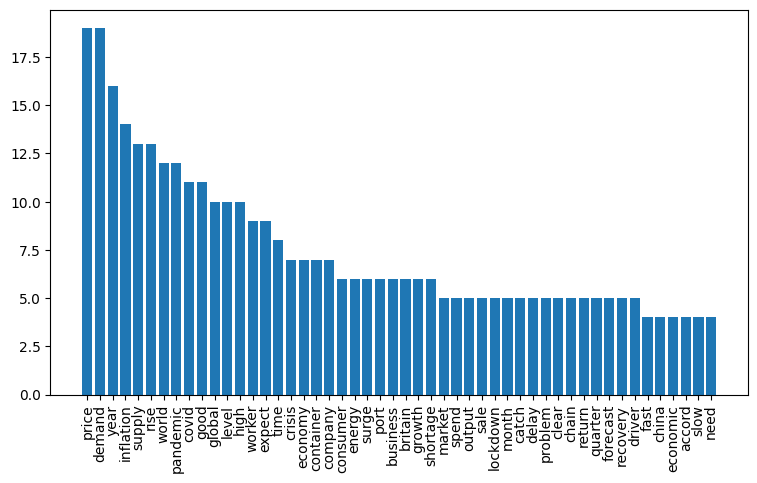

In [56]:
word = [i[0] for i in busiLst[:50]]
freq = [i[1] for i in busiLst[:50]]
plt.figure(figsize = (9,5))
plt.bar(word, freq)
plt.xticks(word, word, rotation = 'vertical')
plt.savefig("process_frequent.png")
plt.show()

In [57]:
fbLst = mostFrequentWord(content = preprocess(footballArt['Content']))
fbLst[:50]

[('messi', 20),
 ('france', 18),
 ('argentina', 14),
 ('mbappe', 13),
 ('world', 12),
 ('time', 11),
 ('penalty', 9),
 ('shoot', 9),
 ('goal', 9),
 ('final', 8),
 ('score', 8),
 ('great', 7),
 ('martinez', 6),
 ('player', 5),
 ('turn', 5),
 ('second', 5),
 ('credit', 5),
 ('getty', 5),
 ('image', 5),
 ('kick', 4),
 ('minute', 4),
 ('maria', 4),
 ('beat', 4),
 ('involve', 3),
 ('best', 3),
 ('year', 3),
 ('save', 3),
 ('ball', 3),
 ('away', 3),
 ('half', 3),
 ('kiss', 3),
 ('tear', 3),
 ('boot', 3),
 ('game', 3),
 ('surely', 3),
 ('explode', 3),
 ('force', 3),
 ('kolo', 3),
 ('muani', 3),
 ('lloris', 3),
 ('lionel', 2),
 ('crown', 2),
 ('kylian', 2),
 ('trick', 2),
 ('trophy', 2),
 ('help', 2),
 ('lose', 2),
 ('decisive', 2),
 ('hero', 2),
 ('coman', 2)]

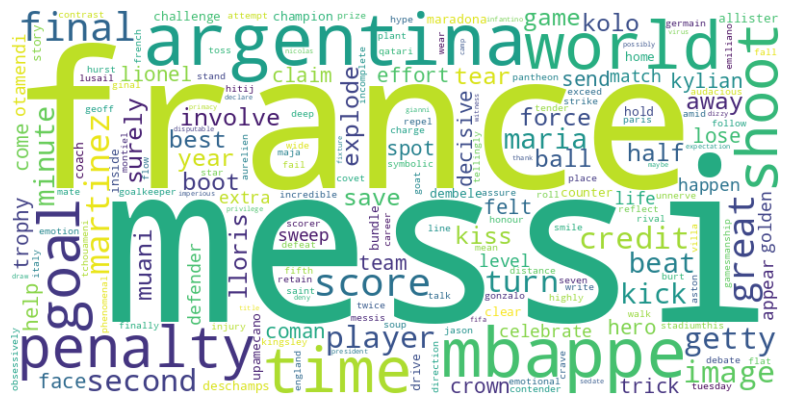

In [59]:
word = [i[0] for i in fbLst[:50]]
freq = [i[1] for i in fbLst[:50]]
total = 0
for i in footballDict:
    total += i[1]
word_freq_dict = dict(fbLst)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.savefig("footballword.png")
plt.show()